In [43]:
import pandas as pd

In [44]:
nba_df = pd.read_csv('nba_pbp.csv')
nba_df = nba_df.drop(index=0)
nba_df.head()

,game_id,data_set,date,a1,a2,a3,a4,a5,h1,h2,...,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
1,42200405,2022-23 Playoffs,6/12/23,Bam Adebayo,Gabe Vincent,Max Strus,Jimmy Butler,Kevin Love,Nikola Jokic,Jamal Murray,...,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
2,42200405,2022-23 Playoffs,6/12/23,Bam Adebayo,Gabe Vincent,Max Strus,Jimmy Butler,Kevin Love,Nikola Jokic,Jamal Murray,...,NaN,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball Jokic vs. Adebayo: Tip to Murray
3,42200405,2022-23 Playoffs,6/12/23,Bam Adebayo,Gabe Vincent,Max Strus,Jimmy Butler,Kevin Love,Nikola Jokic,Jamal Murray,...,bad pass,NaN,Bam Adebayo,bad pass,NaN,NaN,NaN,NaN,NaN,Murray Bad Pass Turnover (P1.T1): Adebayo STEA...
4,42200405,2022-23 Playoffs,6/12/23,Bam Adebayo,Gabe Vincent,Max Strus,Jimmy Butler,Kevin Love,Nikola Jokic,Jamal Murray,...,NaN,made,NaN,dunk,2,5,17,24.5,6.7,Adebayo 2' Running Dunk (2 PTS)
5,42200405,2022-23 Playoffs,6/12/23,Bam Adebayo,Gabe Vincent,Max Strus,Jimmy Butler,Kevin Love,Nikola Jokic,Jamal Murray,...,traveling,NaN,NaN,traveling,NaN,NaN,NaN,NaN,NaN,Porter Jr. Traveling Turnover (P1.T2)


In [45]:
nba_df['converted_x'] = nba_df['converted_x'].astype('float')
nba_df['converted_y'] = nba_df['converted_y'].astype('float')

In [46]:
import pandas as pd
import math

# Define the UDF to determine the shot zone, considering the full court
def determine_shot_zone(x, y, shot_distance):
    basket_1_x, basket_1_y = 25, 5.25
    basket_2_x, basket_2_y = 25, 94 - 5.25

    # Determine which side of the court the shot was taken
    if y <= 47:
        basket_x, basket_y = basket_1_x, basket_1_y
    else:
        basket_x, basket_y = basket_2_x, basket_2_y

    # Calculate distance from the relevant basket
    distance_from_basket = math.sqrt((x - basket_x) ** 2 + (y - basket_y) ** 2)

    # Determine zones
    if distance_from_basket <= 4:
        return "RESTRICTED AREA"
    elif (abs(x - basket_x) <= 6 and ((basket_y == 5.25 and y >= 5.25 and y <= 14) or (basket_y == 88.75 and y >= 79 and y <= 88.75))) and distance_from_basket > 4:
        return "IN THE PAINT (NON-RA)"
    elif distance_from_basket < 22 and ((abs(x - basket_x) > 6) or (abs(y-basket_y) < 17)):
        return "MID-RANGE"
    elif distance_from_basket >= 22 and (x < 14 or x > 44) and ((basket_y == 5.25 and y <= 10) or (basket_y == 88.75 and y >= 84)):
        return "CORNER 3"
    elif float(shot_distance) > 50 or (distance_from_basket > 22 and ((basket_y == 5.25 and y > 10) or (basket_y == 88.75 and y < 84))):
        return "ABOVE THE BREAK 3"
    else:
        return "Unknown Zone"


# Apply the UDF to the DataFrame
nba_df['shot_zone'] = nba_df.apply(lambda row: determine_shot_zone(row['converted_x'], row['converted_y'], row['shot_distance']), axis=1)

In [47]:
nba_df['type'].unique()

array(['start of period', 'jump ball', 'bad pass', 'dunk', 'traveling',
       'driving floating bank jump shot', 'rebound defensive',
       'cutting layup shot', 'jump shot', 'rebound offensive',
       '3pt jump shot', 'lost ball', 'layup', 'offensive charge',
       'offensive foul', 'personal', '3pt step back jump shot',
       '3pt running jump shot', 'driving layup', 'fadeaway jumper',
       'hook shot', 'shooting', 'timeout: regular', 'sub',
       'free throw 1/2', 'team rebound', 'free throw 2/2', 'driving dunk',
       'floating jump shot', 'free throw 1/1', 'loose ball',
       'driving floating jump shot', 'driving reverse layup',
       'jump bank shot', 'turnaround fadeaway', 'end of period',
       'shot clock', 'cutting finger roll layup shot',
       '3pt pullup jump shot', 'step out of bounds',
       '3pt running pull-up jump shot', '3pt fadeaway jumper',
       'hook bank shot', 'kicked ball', 'unknown', 'free throw 1/3',
       'free throw 2/3', 'free throw 3/3',

In [48]:
import pandas as pd
import numpy as np

def find_previous_shot_info(index):
    for i in range(index-1, -1, -1):
        if nba_df.at[i, 'result'] in ['made', 'missed']:
            return nba_df.at[i, 'result'], nba_df.at[i, 'shot_zone']
    return 'missed', 'RESTRICTED AREA'

# Apply the function to create new columns
prev_info = [find_previous_shot_info(i) if nba_df.at[i, 'type'] == 'shooting' else (None, None) for i in range(1,len(nba_df)+1)]
nba_df['prev_result'] = [x[0] for x in prev_info]
nba_df['prev_shot_zone'] = [x[1] for x in prev_info]

# Define conditions and corresponding state values
conditions = [
    (nba_df['event_type'] == 'turnover') | (nba_df['type'].isin(['offensive charge', 'offensive foul'])),
    (nba_df['event_type'] == 'jump ball'),
    (nba_df['event_type'] == 'timeout'),
    (nba_df['event_type'] == 'start of period'),
    (nba_df['event_type'] == 'substitution'),
    (nba_df['event_type'] == 'end of period'),
    (nba_df['type'].isin(['3pt jump shot', '3pt step back jump shot', '3pt running jump shot', '3pt fadeaway jumper', '3pt pullup jump shot', '3pt running pull-up jump shot'])),
    (nba_df['type'].isin(['dunk', 'driving floating bank jump shot', 'floating jump shot', 'cutting layup shot', 'jump shot', 'layup', 'driving layup', 'fadeaway jumper', 
                          'hook shot', 'driving dunk', 'driving floating jump shot', 'driving reverse layup', 'jump bank shot', 'turnaround fadeaway', 
                          'cutting finger roll layup shot', 'hook bank shot', 'layup'])),
    (nba_df['type'] == 'rebound defensive'),
    (nba_df['type'].isin(['rebound offensive', 'team rebound'])),
    (nba_df['event_type'] == 'foul') & (nba_df['type'].isin(['personal', 'personal take'])), 
    (nba_df['event_type'] == 'foul') & (nba_df['type'] == 'shooting') & (nba_df['prev_shot_zone'].isin(['RESTRICTED AREA', 'IN THE PAINT (NON-RA)', 'MID-RANGE'])) & (nba_df['prev_result'] == 'missed'),
    (nba_df['event_type'] == 'foul') & (nba_df['type'] == 'shooting') & (nba_df['prev_shot_zone'].isin(['ABOVE THE BREAK 3', 'CORNER 3'])) & (nba_df['prev_result'] == 'missed'),
    (nba_df['event_type'] == 'foul') & (nba_df['type'] == 'shooting') & (nba_df['result'].shift(1) == 'made')
]

# Define corresponding state values for each condition
state_values = [
    'turnover',
    'jump ball',
    'timeout',
    'start of period', 
    'substitution',
    'end of period',
    '3pt shot',
    '2pt shot',
    'defensive rebound',
    'offensive rebound',
    'Non-shooting foul',
    '2-pt shooting foul',
    '3-pt shooting foul',
    '1-pt shooting foul'
]

# Apply conditions to create the 'state' column
nba_df['state'] = np.select(conditions, state_values, default='OTHER')
nba_df = nba_df[nba_df['state'] != 'OTHER']

In [49]:
nba_df.reset_index(drop=True, inplace=True)

In [50]:
import pandas as pd

# Original dictionary
data = {
    'DEN': {
        'RESTRICTED AREA': 68.1,
        'IN THE PAINT (NON-RA)': 47.7,
        'MID-RANGE': 45.1,
        'LEFT CORNER 3': 35.0,
        'RIGHT CORNER 3': 38.7,
        'CORNER 3': 36.6,
        'ABOVE THE BREAK 3': 38.3
    },
    'MIA': {
        'RESTRICTED AREA': 63.8,
        'IN THE PAINT (NON-RA)': 40.3,
        'MID-RANGE': 43.1,
        'LEFT CORNER 3': 42.7,
        'RIGHT CORNER 3': 38.4,
        'CORNER 3': 40.6,
        'ABOVE THE BREAK 3': 37.3
    }
}
# Convert to DataFrame
df = pd.DataFrame(data)

# Transform zone names to all caps
df.columns = df.columns.str.upper()

In [51]:
with open('pbp.txt', 'w') as file:
    for k,v in zip(nba_df['shot_zone'].values, nba_df['team'].values):
        file.write(str(k) + ', ' + str(v) + '\n')

In [52]:
# Assuming df is your DataFrame containing the shot zone percentages

percentages = []

for zone, team in zip(nba_df['shot_zone'].values, nba_df['team'].values):
    if zone in df.index:
        percentage = df.loc[zone, team] if team in df.columns else 0
    else:
        percentage = 0
        zone = 'Unknown Zone'
        team = 'nan'
    percentages.append(percentage)

nba_df['shot_zone_pctg'] = percentages

In [53]:
nba_df.to_csv('nba_pbp_states.csv')

In [85]:
#absorbing_states = ['turnover', 'defensive rebound', 'end of period']

# Initialize transition matrix
states = nba_df['state'].unique()
transition_matrix = pd.DataFrame(np.zeros((len(states), len(states))), index=states, columns=states)

# Calculate transition counts
for i in range(0, len(nba_df)-1):
    current_state = nba_df.at[i, 'state']
    next_state = nba_df.at[i + 1, 'state']
    transition_matrix.at[current_state, next_state] += 1

# Normalize to get transition probabilities
state_counts = nba_df['state'].value_counts()
for state in states:
    if state == 'end of period':
        transition_matrix.at[state, 'start of period'] = 1
    else:
        transition_matrix.loc[state] = transition_matrix.loc[state] / state_counts[state]

transition_matrix.fillna(0, inplace=True)

In [86]:
state_counts = nba_df['state'].value_counts()
state_proportions = state_counts / len(nba_df)

In [87]:
state_proportions = dict(state_proportions)

In [88]:
state_proportions

{'2pt shot': 0.2819277108433735,
 'defensive rebound': 0.19518072289156627,
 '3pt shot': 0.1493975903614458,
 'substitution': 0.09879518072289156,
 'offensive rebound': 0.0963855421686747,
 'turnover': 0.05783132530120482,
 'Non-shooting foul': 0.02891566265060241,
 'timeout': 0.02891566265060241,
 '1-pt shooting foul': 0.01927710843373494,
 'start of period': 0.00963855421686747,
 '2-pt shooting foul': 0.00963855421686747,
 '3-pt shooting foul': 0.00963855421686747,
 'end of period': 0.00963855421686747,
 'jump ball': 0.004819277108433735}

In [90]:
# Calculate EPV for each event
def calculate_epv(row, state_proportions):
    shot_zone = row['shot_zone']
    shot_zone_pctg = row['shot_zone_pctg']/100 
    if row['team'] == 'DEN':     
        team_ft_pct = 0.801
    else:
        team_ft_pct = 0.813
    if shot_zone in ['CORNER 3', 'ABOVE THE BREAK 3']:
        epv = (
            3 * shot_zone_pctg +
            3 * state_proportions['3-pt shooting foul'] * team_ft_pct +
            2 * state_proportions['2-pt shooting foul'] * team_ft_pct +
            1 * state_proportions['1-pt shooting foul'] * team_ft_pct
        )
    else:
        epv = (
            2 * shot_zone_pctg +
            3 * state_proportions['3-pt shooting foul'] * team_ft_pct +
            2 * state_proportions['2-pt shooting foul'] * team_ft_pct +
            1 * state_proportions['1-pt shooting foul'] * team_ft_pct
        )
    
    #epv *= 1 + offensive_rbd_%
    return epv

# Calculate EPV for each row
nba_df['EPV'] = nba_df.apply(calculate_epv, axis=1, state_proportions=state_proportions)

In [89]:
epv_by_team = nba_df.groupby('team')['EPV'].sum().reset_index()
epv_by_team

,team,EPV
0,DEN,108.296978
1,MIA,110.007602


In [91]:
nba_df['points'] = nba_df['points'].fillna(0)
nba_df['points'] = nba_df['points'].astype(int)
points_by_team = nba_df.groupby('team')['points'].sum().reset_index()
points_by_team

,team,points
0,DEN,81
1,MIA,75


In [92]:
# Shift the 'state' column by one row to get the next state for each event
nba_df['next_state'] = nba_df['state'].shift(-1)

# For the last event in each game, set the next state to an appropriate value (e.g., 'end of period')
nba_df.loc[nba_df['game_id'] != nba_df['game_id'].shift(-1), 'next_state'] = 'end of period'

# Drop rows where 'next_state' is NaN (typically the last event in the dataset)
nba_df = nba_df.dropna(subset=['next_state'])


In [93]:
nba_df.loc[(nba_df['state'] == '2pt shot') & (nba_df['next_state'] == 'offensive rebound'), ['EPV', 'shot_zone']]

,EPV,shot_zone
9,0.860853,IN THE PAINT (NON-RA)
38,1.330853,RESTRICTED AREA
40,0.916853,MID-RANGE
109,0.860853,IN THE PAINT (NON-RA)
111,1.330853,RESTRICTED AREA
114,0.956043,MID-RANGE
116,0.956043,MID-RANGE
123,1.416043,RESTRICTED AREA
125,1.416043,RESTRICTED AREA
148,0.860853,IN THE PAINT (NON-RA)


In [109]:
from collections import defaultdict
import numpy as np
# Function to simulate a single possession with EPV
def simulate_possession_with_epv(initial_state, transition_matrix, nba_df, poss):
    current_state = initial_state
    total_epv = 0  # Initialize total EPV for the possession
    while True:
        # Determine the next state based on the transition probabilities
        next_state = np.random.choice(transition_matrix.columns, p=transition_matrix.loc[current_state])
        
        # If the next state is an absorbing state, end the possession
        
        if current_state in ['2pt shot', '3pt shot']:
            filtered_df = nba_df.loc[(nba_df['state'] == current_state) & (nba_df['next_state'] == next_state) & (nba_df['team'] == poss), ['EPV', 'shot_zone']]
            shot_zone_counts = filtered_df['shot_zone'].value_counts(normalize=True)
            if shot_zone_counts.empty:
                event_epv = 0
            else:
                chosen_shot_zone = np.random.choice(shot_zone_counts.index, p=shot_zone_counts.values)
                event_epv = filtered_df.loc[filtered_df['shot_zone'] == chosen_shot_zone, 'EPV'].mean()
        else:
            event_epv = nba_df.loc[(nba_df['state'] == current_state) & (nba_df['next_state'] == next_state), 'EPV'].mean()
        total_epv += event_epv

        if next_state in ['defensive rebound', 'turnover']:
            return next_state, total_epv
        
        # Update current state for the next iteration
        current_state = next_state

# Simulate multiple possessions with EPV
total_scores = []
wins = defaultdict(int)
for i in range(1000):
    poss = 'DEN'
    track = defaultdict(float)
    total_epv_across_possessions = 0
    state = 'start of period'
    for j in range(100):
        next_state, end_epv = simulate_possession_with_epv(state, transition_matrix, nba_df, poss)
        track[poss] += end_epv
        if poss == 'DEN':
            poss = 'MIA'
        else:
            poss = 'DEN'
        total_epv_across_possessions += end_epv
        state = next_state
    if track['DEN'] > track['MIA']:
        wins['DEN'] += 1
    else:
        wins['MIA'] += 1
    total_scores.append(total_epv_across_possessions)
    

# Print the result
print("Average Simulation Total Game Score:", np.mean(total_scores))
print("Median Simulation Total Game Score:", np.median(total_scores))
print(f"WIN %: MIA - {wins['MIA']/(wins['MIA'] + wins['DEN'])}, DEN - {wins['DEN']/(wins['MIA'] + wins['DEN'])}")

Average Simulation Total Game Score: 205.01239402276818
Median Simulation Total Game Score: 204.50532376725835
WIN %: MIA - 0.342, DEN - 0.658


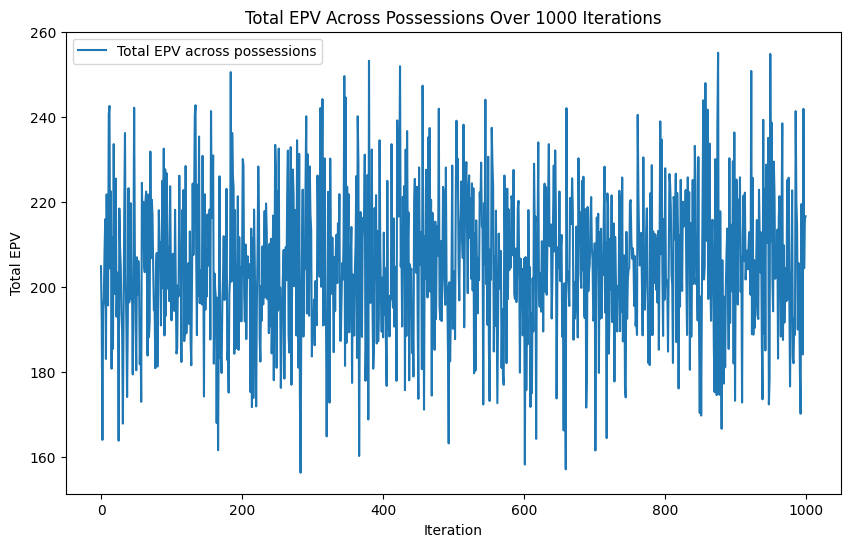

In [110]:
import matplotlib.pyplot as plt

# Plotting the total_scores
plt.figure(figsize=(10, 6))
plt.plot(total_scores, label='Total EPV across possessions')
plt.xlabel('Iteration')
plt.ylabel('Total EPV')
plt.title('Total EPV Across Possessions Over 1000 Iterations')
plt.legend()
plt.show()